In [ ]:
import torch
import numpy as np
import lime.lime_tabular
import shap
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from typing import List, Dict, Optional
from lime.lime_tabular import LimeTabularExplainer

class ECGModelAnalyzer:
    def __init__(self, model, input_size: int = 187, device=None):
        """
        Initialize ECG model analyzer.

        Parameters:
        - model (torch.nn.Module): The trained PyTorch model to analyze.
        - input_size (int): Number of time steps in each ECG sample (default: 187).
        - device (torch.device or str, optional): Device to run the model on ('cuda' or 'cpu').
        """
        self.input_size = input_size
        self.class_names = ['Normal', 'Supraventricular', 'Ventricular', 'Fusion', 'Unknown']

        # Configure GPU memory management
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.set_per_process_memory_fraction(0.8)
            torch.backends.cuda.matmul.allow_tf32 = True

        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self._prepare_model(model)

    def _prepare_model(self, model):
        """
        Move model to the selected device with error handling.

        Parameters:
        - model (torch.nn.Module): The model to prepare.

        Returns:
        - torch.nn.Module: Model moved to the appropriate device.
        """
        try:
            model.to(self.device)
            if self.device.type == 'cuda':
                torch.cuda.synchronize()
        except RuntimeError as e:
            print(f"CUDA error: {e}. Falling back to CPU.")
            self.device = torch.device('cpu')
            model.to(self.device)
        return model

    def _safe_to_device(self, tensor):
        """
        Move tensor to device safely, with fallback to CPU if needed.

        Parameters:
        - tensor (torch.Tensor): Tensor to move.

        Returns:
        - torch.Tensor: Tensor on the appropriate device.
        """
        try:
            return tensor.to(self.device)
        except RuntimeError as e:
            print(f"CUDA memory error: {e}")
            torch.cuda.empty_cache()
            gc.collect()
            try:
                return tensor.to(self.device)
            except RuntimeError:
                print("Fallback to CPU for tensor.")
                self.device = torch.device('cpu')
                return tensor.to(self.device)

    def prepare_lime_explainer(self, training_data: np.ndarray) -> LimeTabularExplainer:
        """
        Prepare LIME explainer using flattened training data.

        Parameters:
        - training_data (np.ndarray): ECG training data of shape (samples, time_steps).

        Returns:
        - LimeTabularExplainer: Configured LIME explainer.
        """
        try:
            with torch.cuda.device(self.device):
                flattened = training_data.reshape(training_data.shape[0], -1)
                feature_names = [f'time_{i}' for i in range(flattened.shape[1])]
                return LimeTabularExplainer(
                    flattened,
                    feature_names=feature_names,
                    class_names=self.class_names,
                    mode='regression'
                )
        except Exception as e:
            print(f"LIME explainer error: {e}")
            raise

    def model_prediction_wrapper(self, data: np.ndarray) -> np.ndarray:
        """
        Predict model output for input data with shape validation and batching.

        Parameters:
        - data (np.ndarray): Input ECG data of shape (time_steps,) or (samples, time_steps).

        Returns:
        - np.ndarray: Softmax probabilities for each class.
        """
        self.model.eval()
        try:
            with torch.no_grad():
                # Reshape to (batch, input_size, 1)
                if data.ndim == 1:
                    data = data.reshape(1, self.input_size, 1)
                elif data.ndim == 2:
                    data = data.reshape(data.shape[0], self.input_size, 1)

                if data.shape[1] != self.input_size:
                    raise ValueError(f"Expected input size {self.input_size}, got {data.shape[1]}")

                # Batch processing
                batch_size = 32
                if data.shape[0] > batch_size:
                    preds = [self._process_batch(data[i:i+batch_size]) for i in range(0, data.shape[0], batch_size)]
                    return np.vstack(preds)
                else:
                    return self._process_batch(data)
        except RuntimeError as e:
            print(f"Prediction error: {e}")
            torch.cuda.empty_cache()
            return self._process_batch(data, use_cpu=True)

    def _process_batch(self, batch: np.ndarray, use_cpu: bool = False) -> np.ndarray:
        """
        Run model on a batch and return softmax probabilities.

        Parameters:
        - batch (np.ndarray): Batch of ECG samples of shape (batch_size, time_steps, 1).
        - use_cpu (bool): Whether to force processing on CPU.

        Returns:
        - np.ndarray: Predicted probabilities for each sample.
        """
        device = torch.device('cpu') if use_cpu else self.device
        batch_tensor = torch.FloatTensor(batch).to(device)
        result = self.model(batch_tensor)
        outputs = result[0] if isinstance(result, (tuple, list)) else result
        probs = torch.softmax(outputs, dim=1)
        return probs.cpu().numpy()

    def analyze_single_sample(self, sample: np.ndarray, explainer: LimeTabularExplainer, num_features: int = 10) -> Optional[Dict]:
        """
        Run LIME analysis on a single sample.

        Parameters:
        - sample (np.ndarray): ECG sample of shape (time_steps,) or (time_steps, 1).
        - explainer (LimeTabularExplainer): Preconfigured LIME explainer.
        - num_features (int): Number of top features to include in explanation.

        Returns:
        - dict or None: Explanation, prediction, and feature importance.
        """
        try:
            if sample.ndim == 1:
                sample = sample.reshape(-1, 1)
            flattened = sample.reshape(-1)
            torch.cuda.empty_cache()

            explanation = explainer.explain_instance(
                flattened,
                self.model_prediction_wrapper,
                num_features=num_features,
                top_labels=len(self.class_names)
            )

            pred = self.model_prediction_wrapper(flattened.reshape(1, self.input_size, 1))

            return {
                'explanation': explanation,
                'prediction': pred[0] if pred is not None else None,
                'feature_importance': explanation.as_list()
            }
        except Exception as e:
            print(f"Sample analysis error: {e}")
            return None

    def visualize_lime_explanation(self, sample: np.ndarray, analysis_result: Optional[Dict], save_path: str = None):
        """
        Visualize ECG signal and LIME feature importance.

        Parameters:
        - sample (np.ndarray): Original ECG sample.
        - analysis_result (dict): Output from analyze_single_sample.
        - save_path (str, optional): Path to save the plot image.
        """
        if analysis_result is None:
            print("No analysis result to visualize.")
            return

        try:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

            # ECG signal plot
            ax1.plot(sample.flatten())
            ax1.set_title('Original ECG Signal')
            ax1.set_xlabel('Time')
            ax1.set_ylabel('Amplitude')

            # Feature importance plot
            if analysis_result.get('feature_importance'):
                df = pd.DataFrame(analysis_result['feature_importance'], columns=['Feature', 'Importance'])
                sns.barplot(data=df, x='Importance', y='Feature', ax=ax2)
                ax2.set_title('Feature Importance (LIME)')
            else:
                ax2.text(0.5, 0.5, 'No feature importance available', ha='center', va='center')

            plt.tight_layout()
            if save_path:
                plt.savefig(save_path)
            plt.show()
        except Exception as e:
            print(f"Visualization error: {e}")
            plt.close()

    def analyze_dataset(self, data: np.ndarray, samples_to_analyze: int = 5) -> List[Dict]:
        """
        Analyze multiple samples from dataset using LIME.

        Parameters:
        - data (np.ndarray): ECG dataset of shape (samples, time_steps).
        - samples_to_analyze (int): Number of random samples to analyze.

        Returns:
        - List[Dict]: List of analysis results per sample.
        """
        results = []
        try:
            explainer = self.prepare_lime_explainer(data)
            indices = np.random.choice(len(data), samples_to_analyze, replace=False)

            for idx in indices:
                sample = data[idx]
                result = self.analyze_single_sample(sample, explainer)
                if result:
                    results.append({'sample_idx': idx, 'analysis': result})
                    self.visualize_lime_explanation(sample, result)
            return results
        except Exception as e:
            print(f"Dataset analysis error: {e}")
            return results

    def get_model_summary(self) -> Dict:
        """
        Return model architecture and parameter statistics.

        Returns:
        - dict: Summary including total/trainable parameters and device info.
        """
        total = sum(p.numel() for p in self.model.parameters())
        trainable = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        return {
            'total_parameters': total,
            'trainable_parameters': trainable,
            'model_architecture': str(self.model),
            'device': str(self.device)
        }

    def analyze_attention_weights(self, sample: np.ndarray) -> np.ndarray:
        """
        Extract attention weights from model output.

        Parameters:
        - sample (np.ndarray): ECG sample of shape (time_steps,) or (time_steps, 1).

        Returns:
        - np.ndarray: Attention weights from the model.
        """
        self.model.eval()
        with torch.no_grad():
            tensor = torch.FloatTensor(sample).unsqueeze(0).to(self.device)
            _, attn_weights = self.model(tensor)
            return attn_weights.cpu().numpy()

    def get_memory_stats(self) -> Dict:
        """
        Report current GPU memory usage.

        Returns:
        - dict: Memory statistics (allocated, cached, max allocated) or CPU fallback.
        """
        if self.device.type == 'cuda':
            return {
                'allocated': torch.cuda.memory_allocated(self.device) / 1024**2,
                'cached': torch.cuda.memory_reserved(self.device) / 1024**2,
                'max_allocated': torch.cuda.max_memory_allocated(self.device) / 1024**2
            }
        return {'device': 'cpu'}

f:\NTU Projects\sc4001-1\buh\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def display_samples_by_class(model, data, labels, input_size):
    """
    Display one analyzed ECG sample per class using LIME explanations.

    Parameters:
    - model (torch.nn.Module): Trained ECG classification model.
    - data (np.ndarray): ECG dataset of shape (samples, time_steps).
    - labels (np.ndarray): Array of integer class labels for each sample.
    - input_size (int): Number of time steps per sample (e.g., 187).
    """
    analyzer = ECGModelAnalyzer(model, input_size=input_size)
    class_names = ['Normal', 'Supraventricular', 'Ventricular', 'Fusion', 'Unknown']

    print(f"\n--- One sample for each class from {model.model_name} ---")

    # Loop through each class and display one sample
    for class_idx, class_name in enumerate(class_names):
        # Find indices of samples belonging to the current class
        class_indices = np.where(labels == class_idx)[0]

        if len(class_indices) == 0:
            print(f"\nNo samples found for class: {class_name}")
            continue

        # Randomly select one sample from the class
        sample_idx = np.random.choice(class_indices)
        sample_data = data[sample_idx]

        # Run LIME analysis on the selected sample
        explainer = analyzer.prepare_lime_explainer(data)
        analysis = analyzer.analyze_single_sample(sample_data, explainer)

        print(f"\nClass: {class_name} (Sample Index: {sample_idx})")
        print("-" * 50)

        if analysis and 'prediction' in analysis:
            predictions = analysis['prediction']

            # Print class probabilities
            print("\nClass Probabilities:")
            for cls_name, prob in zip(class_names, predictions):
                print(f"{cls_name}: {prob:.4f}")

            # Print predicted class and confidence
            pred_class = np.argmax(predictions)
            confidence = predictions[pred_class]
            print(f"\nPredicted Class: {class_names[pred_class]}")
            print(f"Confidence: {confidence:.4f}")

            # Create visualization
            plt.figure(figsize=(15, 12))

            # Plot 1: Original ECG signal
            plt.subplot(3, 1, 1)
            plt.plot(sample_data.flatten(), 'b-', label='ECG Signal')
            plt.title(f'{class_name} - Original ECG Signal')
            plt.xlabel('Time')
            plt.ylabel('Amplitude')
            plt.legend()
            plt.grid(True)

            # Plot 2: Top 10 LIME feature importances
            if 'feature_importance' in analysis:
                plt.subplot(3, 1, 2)
                importance_df = pd.DataFrame(
                    analysis['feature_importance'][:10],
                    columns=['Feature', 'Importance']
                )
                sns.barplot(data=importance_df, x='Importance', y='Feature')
                plt.title(f'{class_name} - Top 10 Important Features')

            # Plot 3: Class probability bar chart
            plt.subplot(3, 1, 3)
            plt.bar(class_names, predictions)
            plt.title(f'{class_name} - Class Probabilities')
            plt.xticks(rotation=45)
            plt.ylabel('Probability')

            plt.tight_layout()
            plt.show()

            print("\n" + "=" * 80 + "\n")

In [ ]:
def run_class_analysis(model, data, labels, input_size):
    """
    Run LIME-based analysis and visualization for one sample from each ECG class.

    Parameters:
    - model (torch.nn.Module): Trained ECG classification model.
    - data (np.ndarray): ECG dataset of shape (samples, time_steps).
    - labels (np.ndarray): Array of integer class labels corresponding to each sample.
    - input_size (int): Number of time steps per sample (e.g., 187).

    This function calls `display_samples_by_class` to:
    - Select one random sample per class
    - Run LIME explanation
    - Visualize signal, feature importance, and class probabilities
    """
    try:
        display_samples_by_class(model, data, labels, input_size)
    except Exception as e:
        print(f"Error during analysis: {e}")

In [4]:
import torch
import numpy as np
from utils.training.training import *
from utils.architectures.gru import *
from utils.architectures.hybrid import *
from utils.preprocessing import *

In [5]:
import pandas as pd
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

class NewECGDataProcessor:
    """
    Class to handle ECG data preprocessing for multiple datasets
    """
    def __init__(self, mitbih_train_path, mitbih_test_path, incart_path):
        self.mitbih_train_path = mitbih_train_path
        self.mitbih_test_path = mitbih_test_path
        self.incart_path = incart_path
        self.scaler = StandardScaler()

    def load_and_preprocess_mitbih(self):
        """
        Load and preprocess MIT-BIH test dataset
        """
        print("Loading MIT-BIH dataset...")
        df_train = pd.read_csv(self.mitbih_train_path, header=None)
        df_test = pd.read_csv(self.mitbih_test_path, header=None)

        # Separate features and labels
        X_train = df_train.iloc[:, :-1].values
        y_train = df_train.iloc[:, -1].values
        X_test = df_test.iloc[:, :-1].values
        y_test = df_test.iloc[:, -1].values

        print(f"MIT-BIH dataset shape: {X_train.shape}")
        self._print_class_distribution("MIT-BIH", y_train)

        return X_train, y_train,X_test, y_test

    def _print_class_distribution(self, dataset_name, y):
        """
        Print class distribution for a dataset
        """
        print(f"\nClass distribution in {dataset_name} dataset:")
        classes = np.unique(y)
        for class_id in classes:
            count = np.sum(y == class_id)
            percentage = (count / len(y)) * 100
            print(f"Class {class_id}: {count} samples ({percentage:.2f}%)")

    def preprocess_mitbih_data(self):
        print("Loading MIT-BIH dataset...")
        df_train = pd.read_csv(self.mitbih_train_path, header=None)
        df_test = pd.read_csv(self.mitbih_test_path, header=None)

        # Separate features and labels
        X_train = df_train.iloc[:, :-1].values
        y_train = df_train.iloc[:, -1].values
        X_test = df_test.iloc[:, :-1].values
        y_test = df_test.iloc[:, -1].values

        print(f"MIT-BIH dataset shape: {X_train.shape}")
        self._print_class_distribution("MIT-BIH", y_train)

        # Split before applying SMOTE
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train,
            test_size=0.1,
            random_state=42,
            stratify=y_train
        )

        # Apply SMOTE to training data only
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)

        # Reshape for RNN input
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

        return X_train, X_val, X_test, y_train, y_val, y_test

In [6]:
# Set file paths
incart_path = 'INCART 2-lead Arrhythmia Database.csv'
mitbih_train_path = 'data/mitbih_train.csv'
mitbih_test_path = 'data/mitbih_test.csv'

# Create processor instance
processor = NewECGDataProcessor(mitbih_train_path, mitbih_test_path, incart_path)

# Load and preprocess data
X_train, X_val, X_test, y_train, y_val, y_test = processor.preprocess_mitbih_data()

# Print final dataset sizes
print("\nFinal dataset sizes:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Loading MIT-BIH dataset...
MIT-BIH dataset shape: (87554, 187)

Class distribution in MIT-BIH dataset:
Class 0.0: 72471 samples (82.77%)
Class 1.0: 2223 samples (2.54%)
Class 2.0: 5788 samples (6.61%)
Class 3.0: 641 samples (0.73%)
Class 4.0: 6431 samples (7.35%)

Final dataset sizes:
Training set: (326115, 187, 1)
Validation set: (8756, 187, 1)
Test set: (21892, 187, 1)


In [7]:
 # Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    X_train, X_val, X_test, y_train, y_val, y_test
)

In [8]:
config = get_training_config()

In [9]:
checkpt = torch.load('models/best_CNN-RNN/best_model.pth', map_location='cuda', weights_only=False)

model_name = 'CNN-RNN'
model_params = config[model_name]['model_params']

hybrid_model = ECG_CNN_RNN(**model_params)

hybrid_model.load_state_dict(checkpt['model_state_dict'])

<All keys matched successfully>

In [10]:
checkpt = torch.load('models/best_GRU/best_model.pth', map_location='cuda', weights_only=False)

model_name = 'GRU'
model_params = config[model_name]['model_params']

gru_model = AttentionRNN(**model_params)

gru_model.load_state_dict(checkpt['model_state_dict'])

<All keys matched successfully>


--- One sample for each class from CNN-RNN ---

Class: Normal (Sample Index: 17390)
--------------------------------------------------

Class Probabilities:
Normal: 0.9661
Supraventricular : 0.0082
Ventricular: 0.0088
Fusion: 0.0079
Unknown: 0.0090

Predicted Class: Normal
Confidence: 0.9661


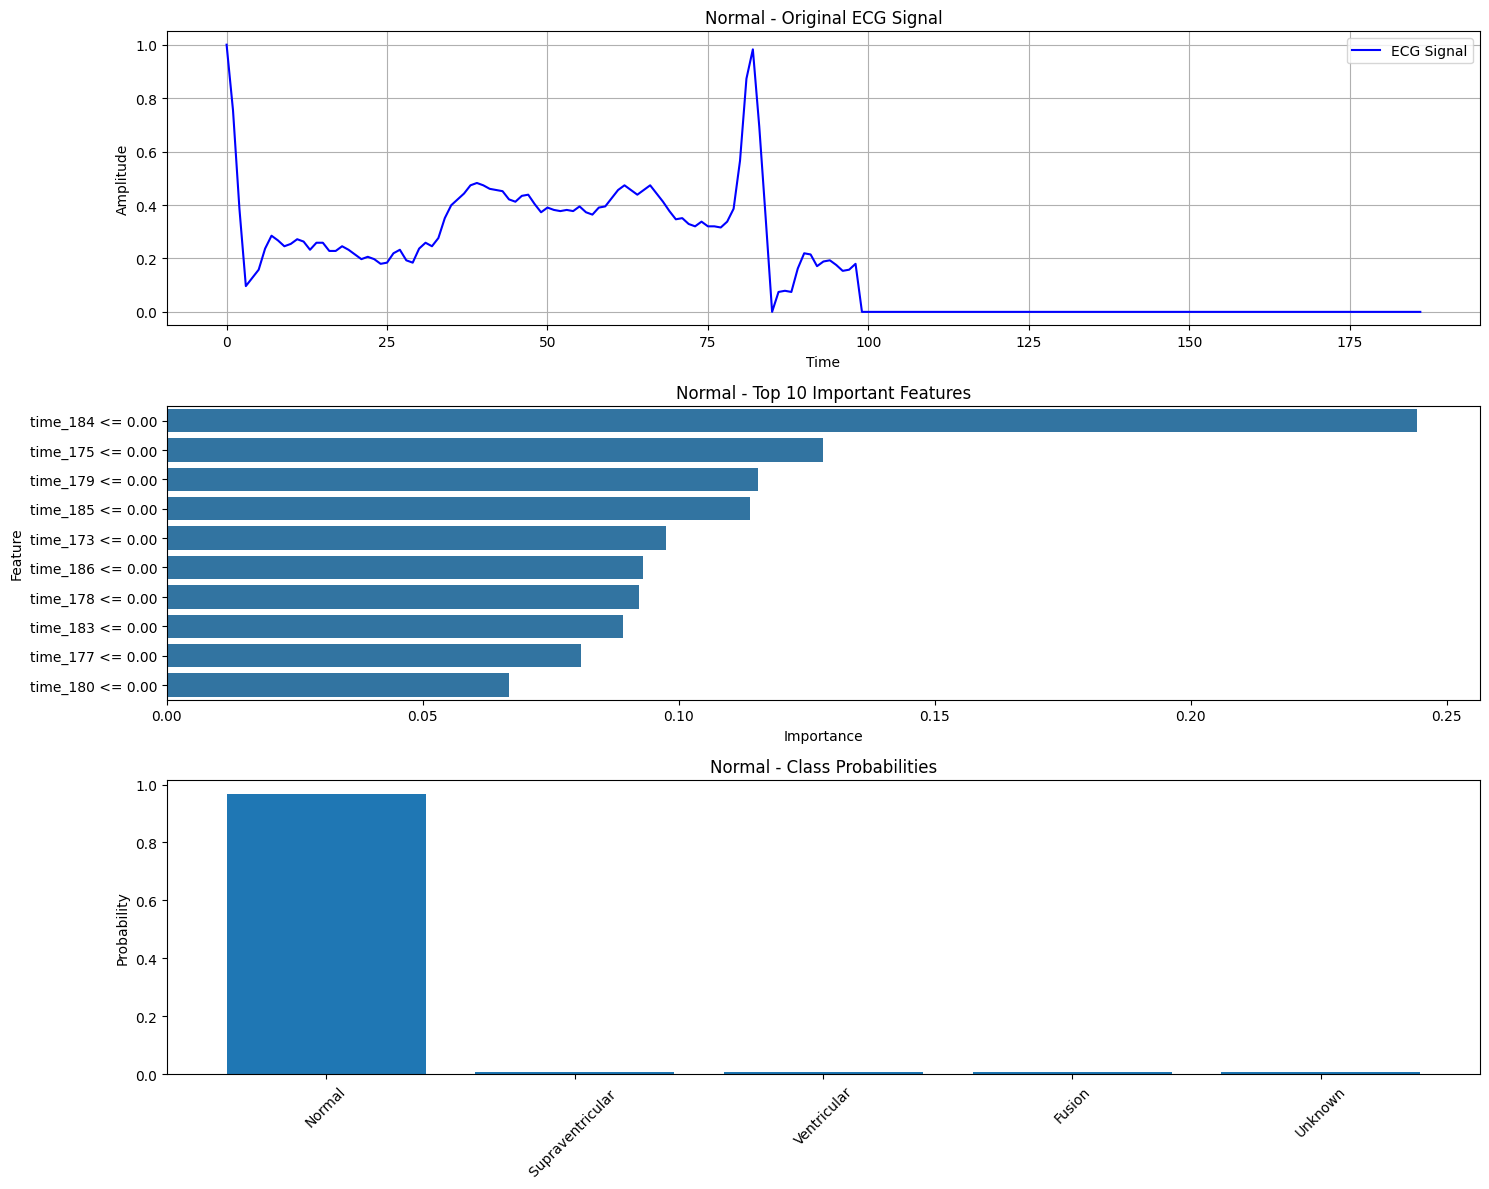




Class: Supraventricular  (Sample Index: 18232)
--------------------------------------------------

Class Probabilities:
Normal: 0.0109
Supraventricular : 0.9620
Ventricular: 0.0092
Fusion: 0.0087
Unknown: 0.0091

Predicted Class: Supraventricular 
Confidence: 0.9620


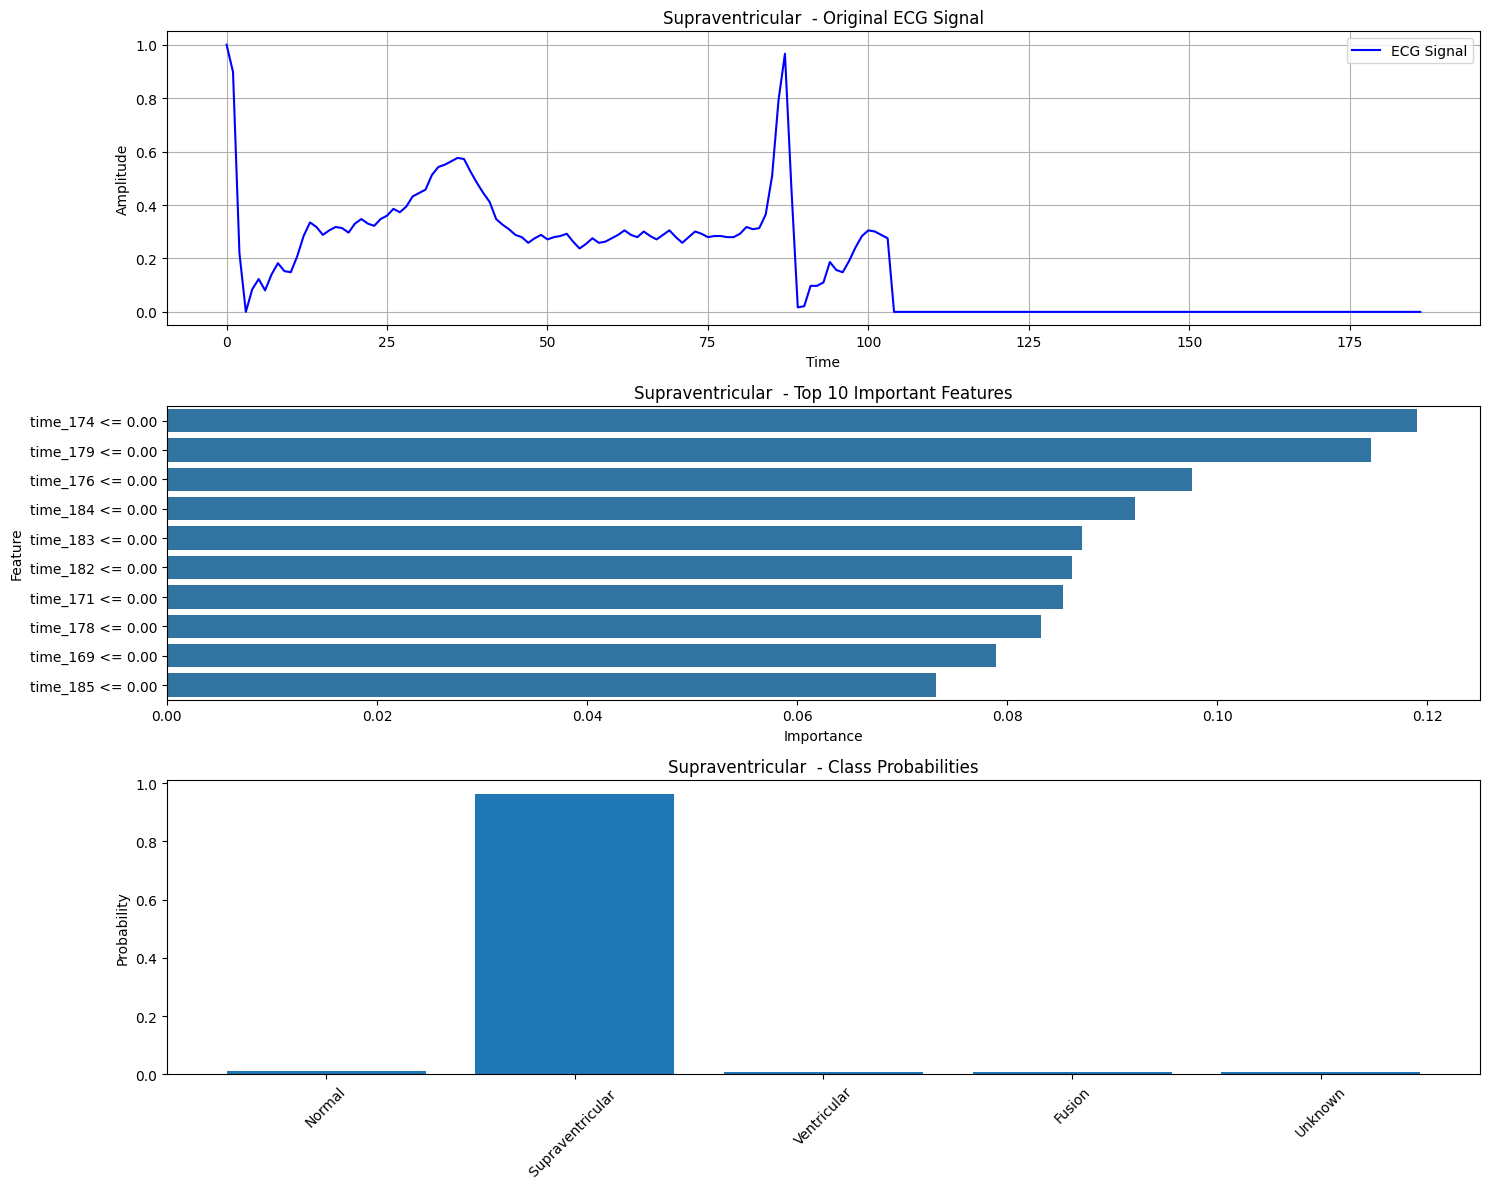




Class: Ventricular (Sample Index: 19535)
--------------------------------------------------

Class Probabilities:
Normal: 0.0087
Supraventricular : 0.0080
Ventricular: 0.9674
Fusion: 0.0078
Unknown: 0.0081

Predicted Class: Ventricular
Confidence: 0.9674


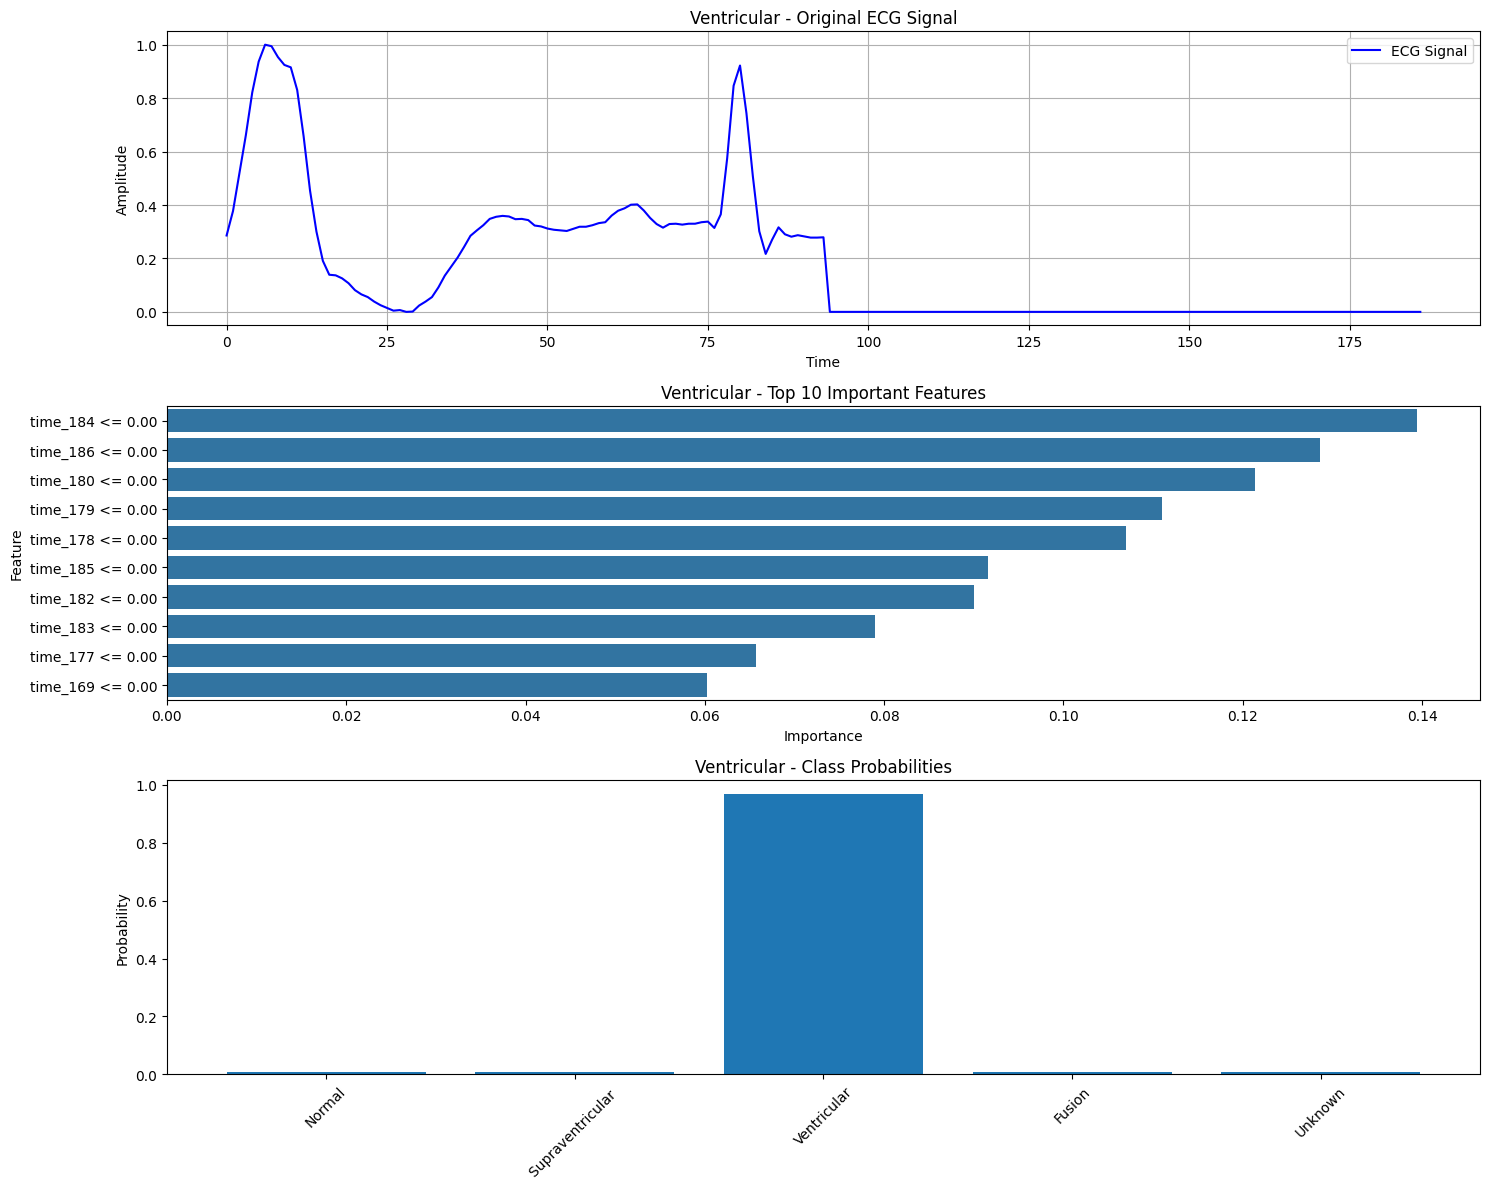




Class: Fusion (Sample Index: 20268)
--------------------------------------------------

Class Probabilities:
Normal: 0.0120
Supraventricular : 0.0083
Ventricular: 0.0103
Fusion: 0.9607
Unknown: 0.0086

Predicted Class: Fusion
Confidence: 0.9607


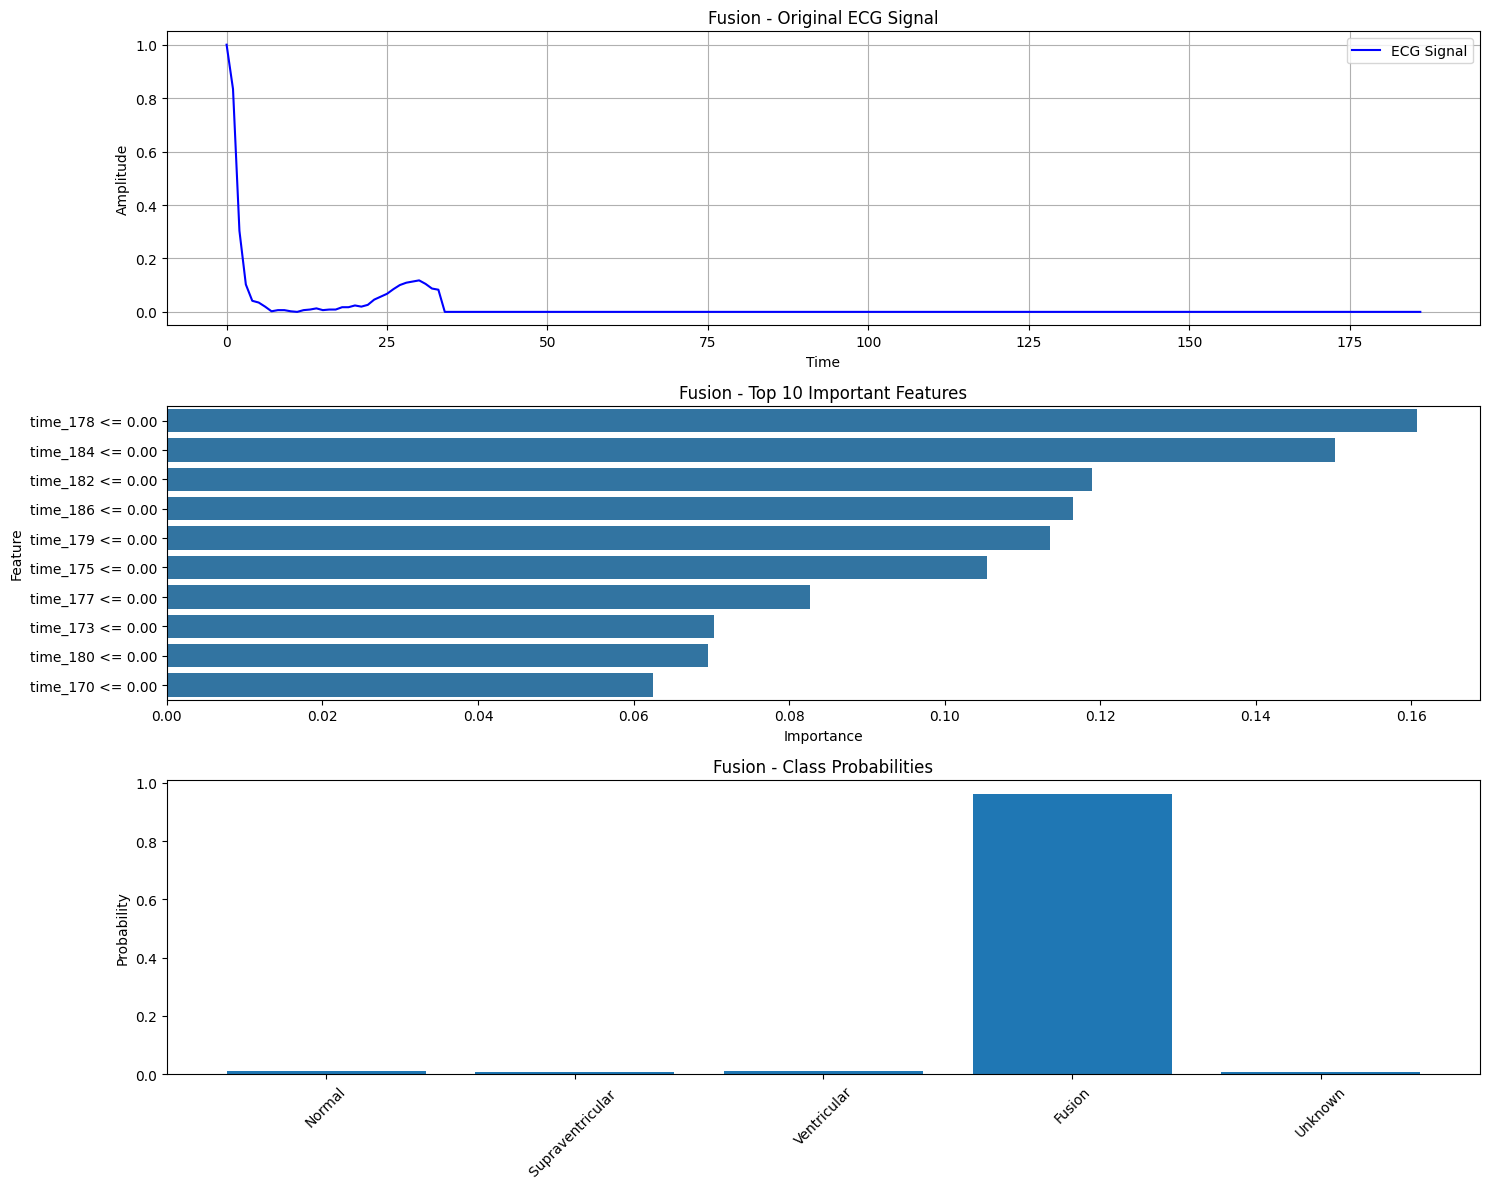




Class: Unknown (Sample Index: 21824)
--------------------------------------------------

Class Probabilities:
Normal: 0.0103
Supraventricular : 0.0102
Ventricular: 0.0118
Fusion: 0.0091
Unknown: 0.9587

Predicted Class: Unknown
Confidence: 0.9587


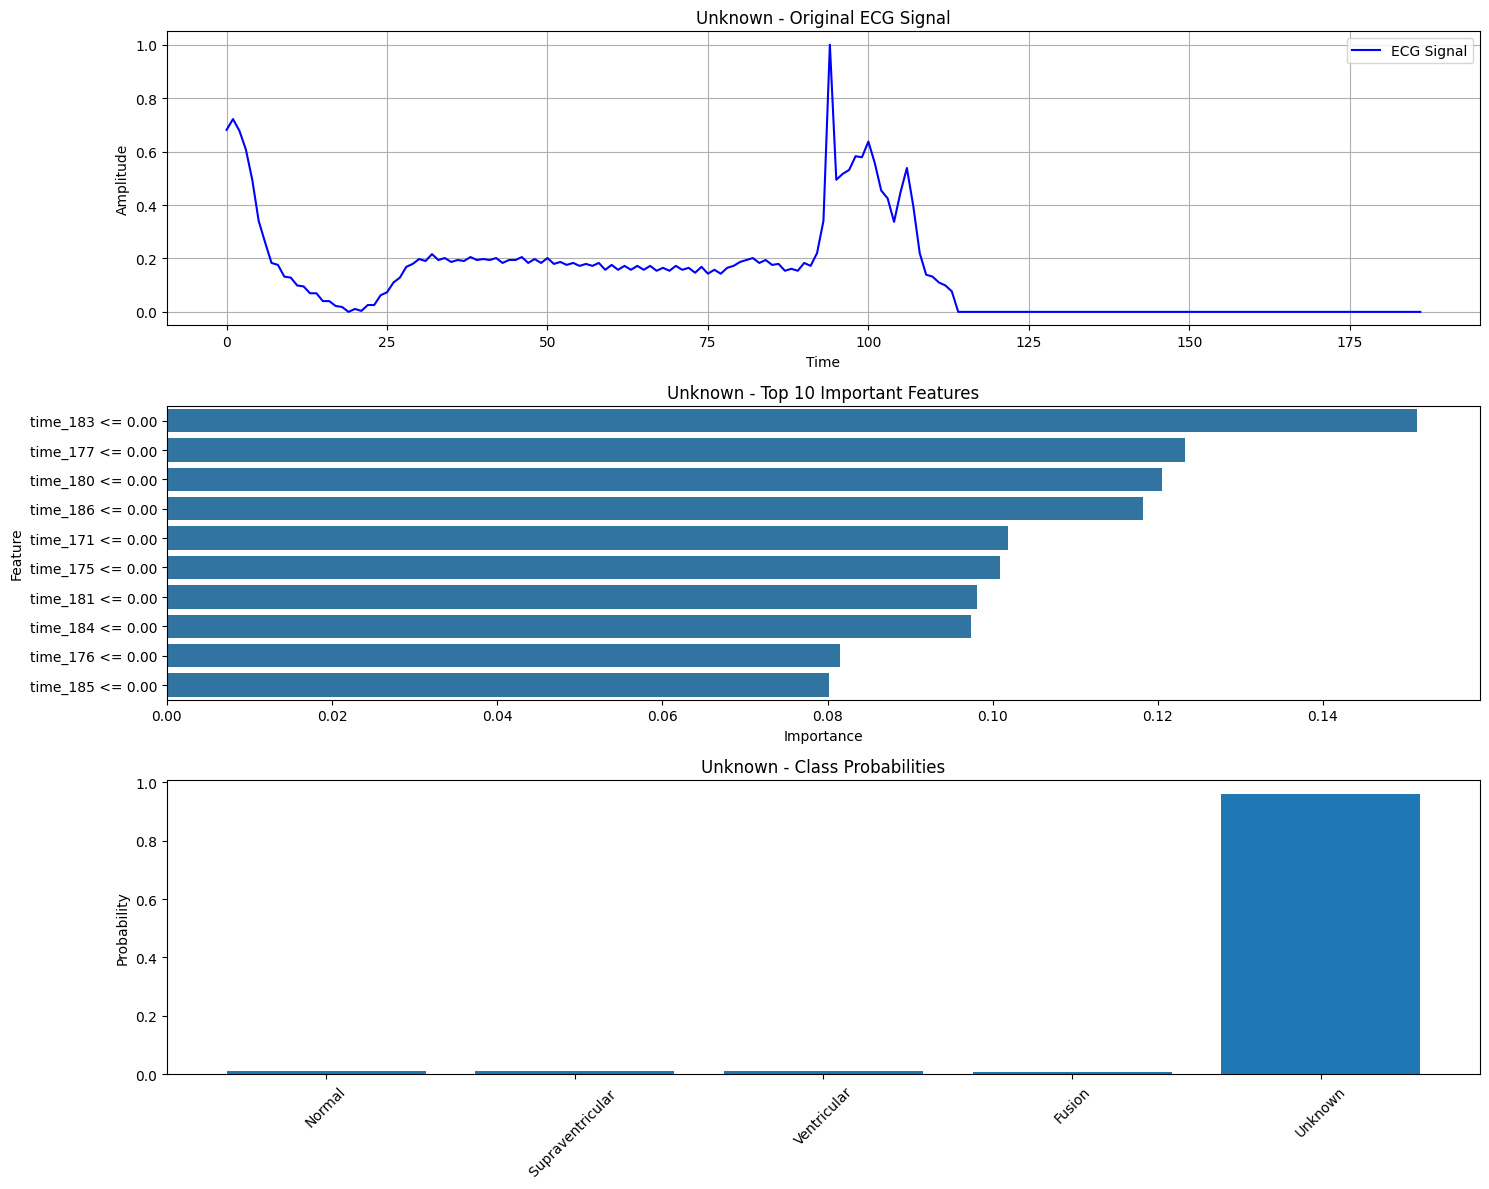

In [11]:
run_class_analysis(hybrid_model, X_test, y_test, 187)


--- One sample for each class from GRU ---

Class: Normal (Sample Index: 8884)
--------------------------------------------------

Class Probabilities:
Normal: 0.9634
Supraventricular : 0.0065
Ventricular: 0.0106
Fusion: 0.0114
Unknown: 0.0082

Predicted Class: Normal
Confidence: 0.9634


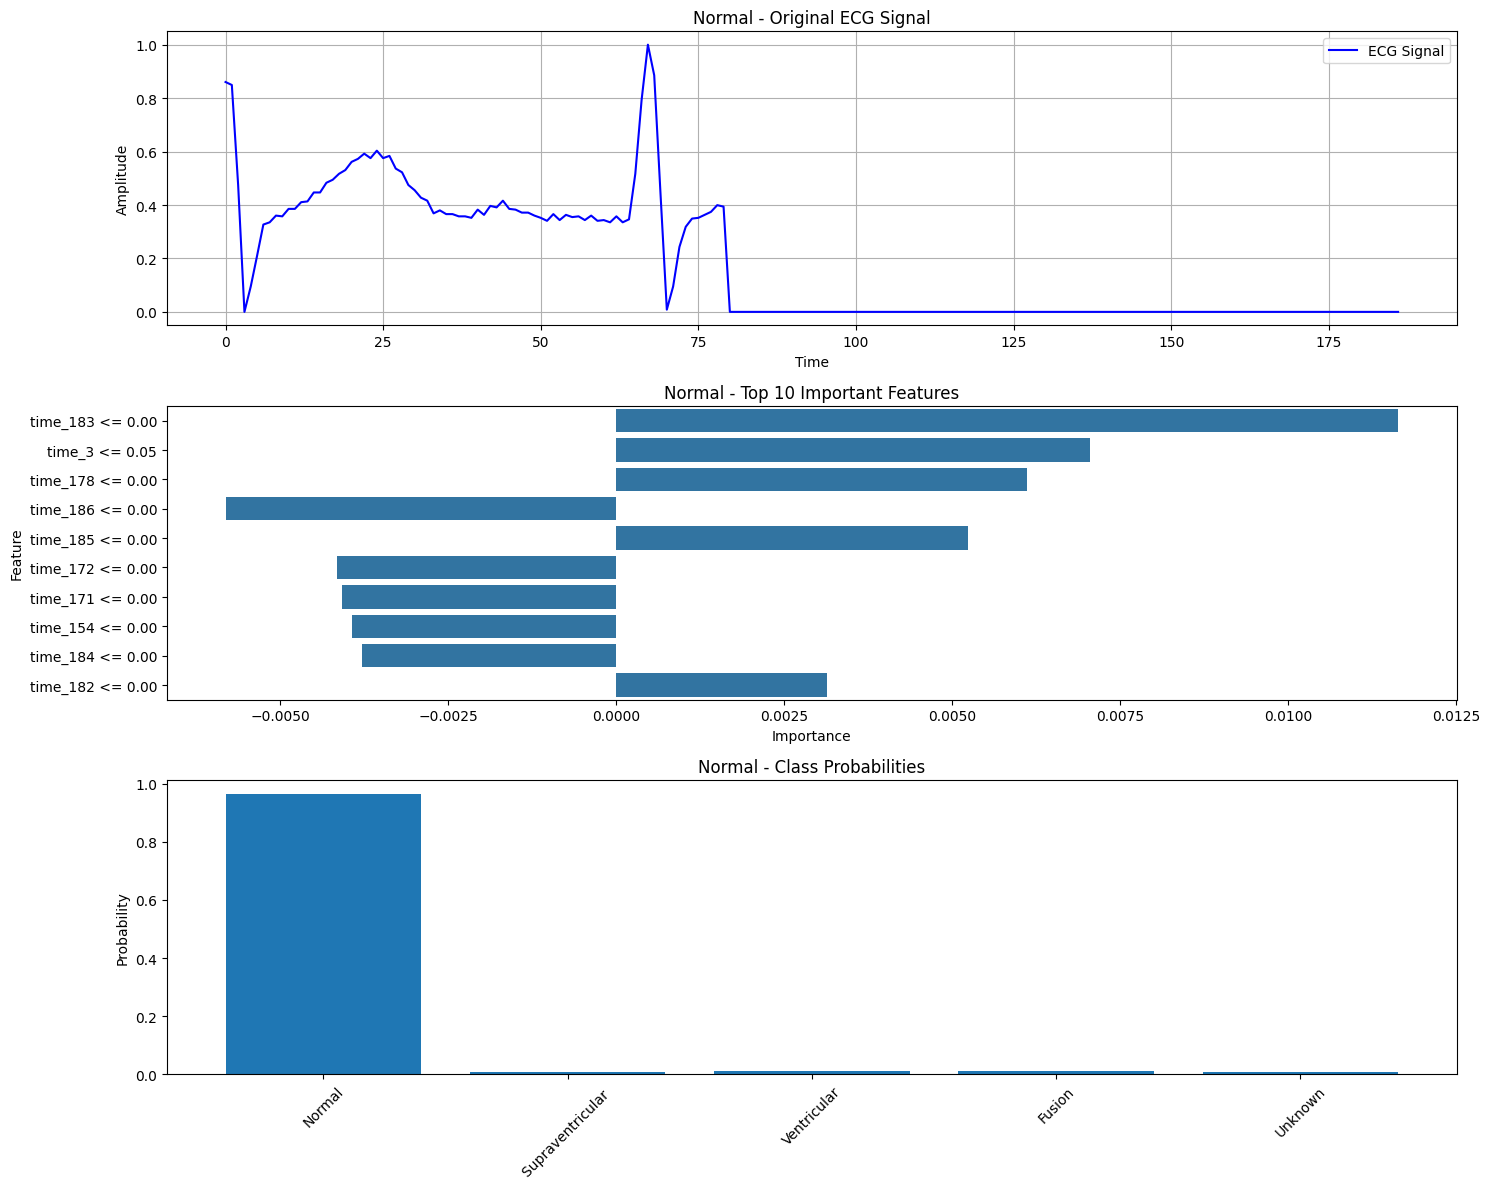




Class: Supraventricular  (Sample Index: 18631)
--------------------------------------------------

Class Probabilities:
Normal: 0.0113
Supraventricular : 0.9707
Ventricular: 0.0032
Fusion: 0.0064
Unknown: 0.0085

Predicted Class: Supraventricular 
Confidence: 0.9707


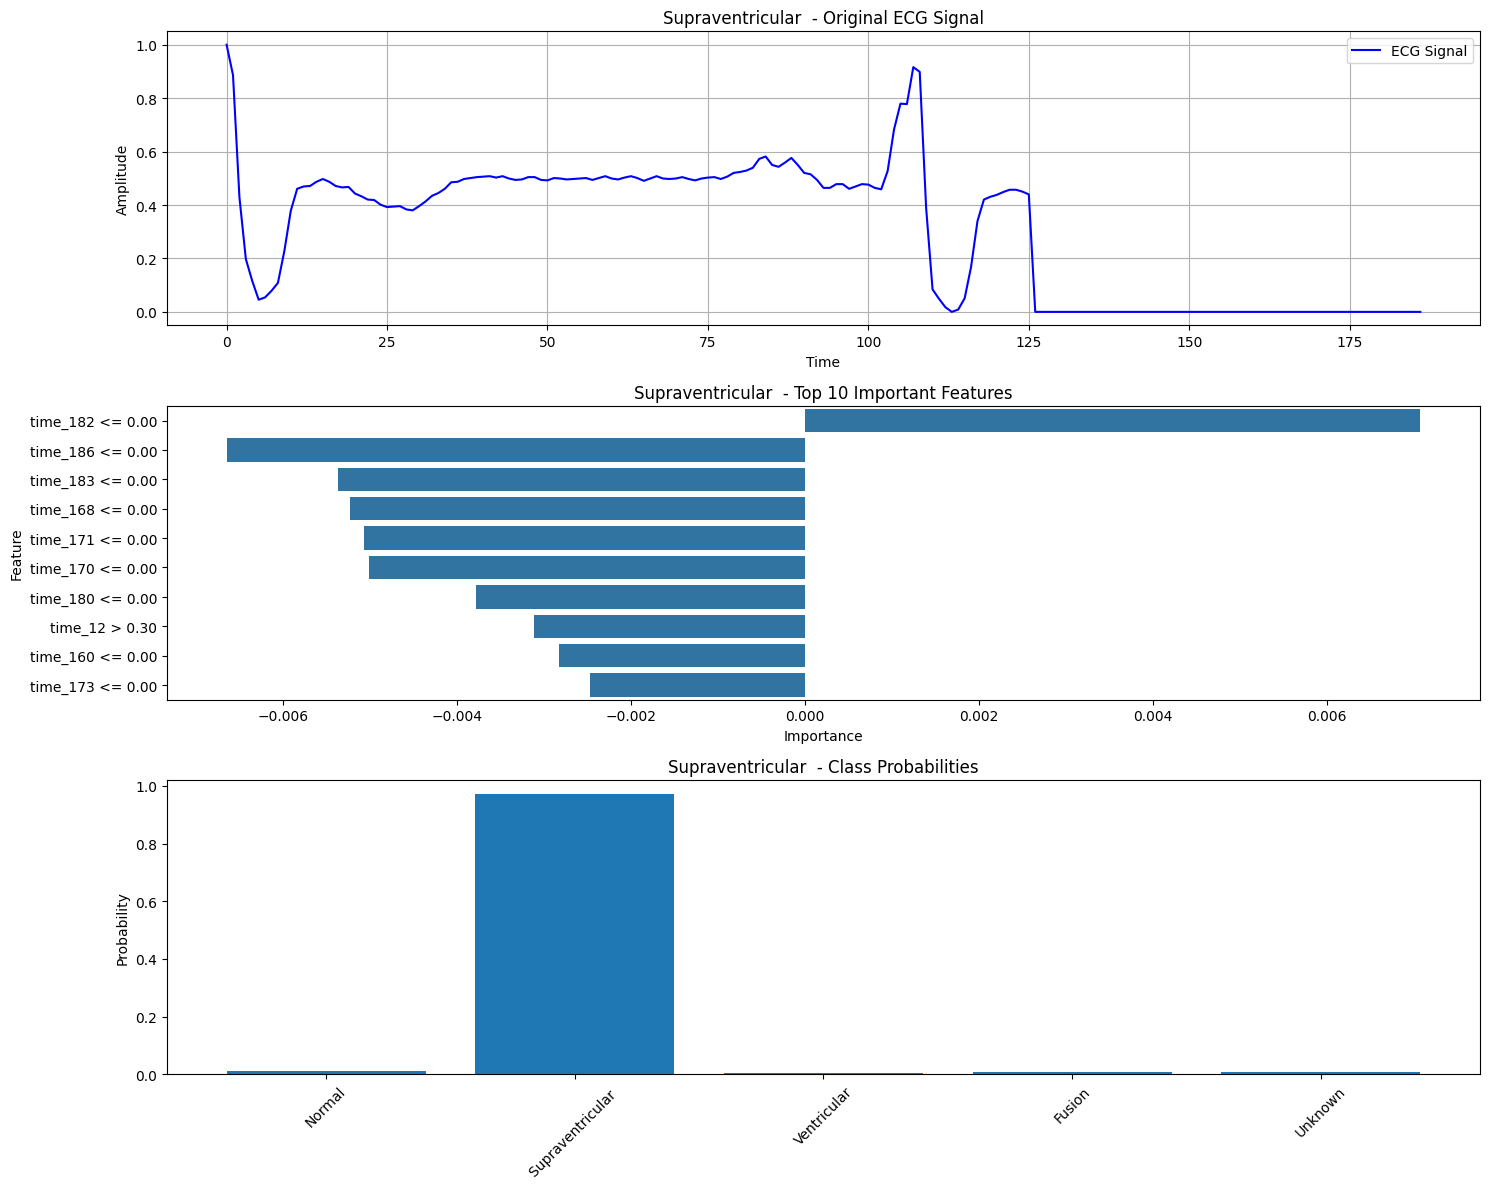




Class: Ventricular (Sample Index: 19134)
--------------------------------------------------

Class Probabilities:
Normal: 0.2718
Supraventricular : 0.0836
Ventricular: 0.5225
Fusion: 0.0258
Unknown: 0.0964

Predicted Class: Ventricular
Confidence: 0.5225


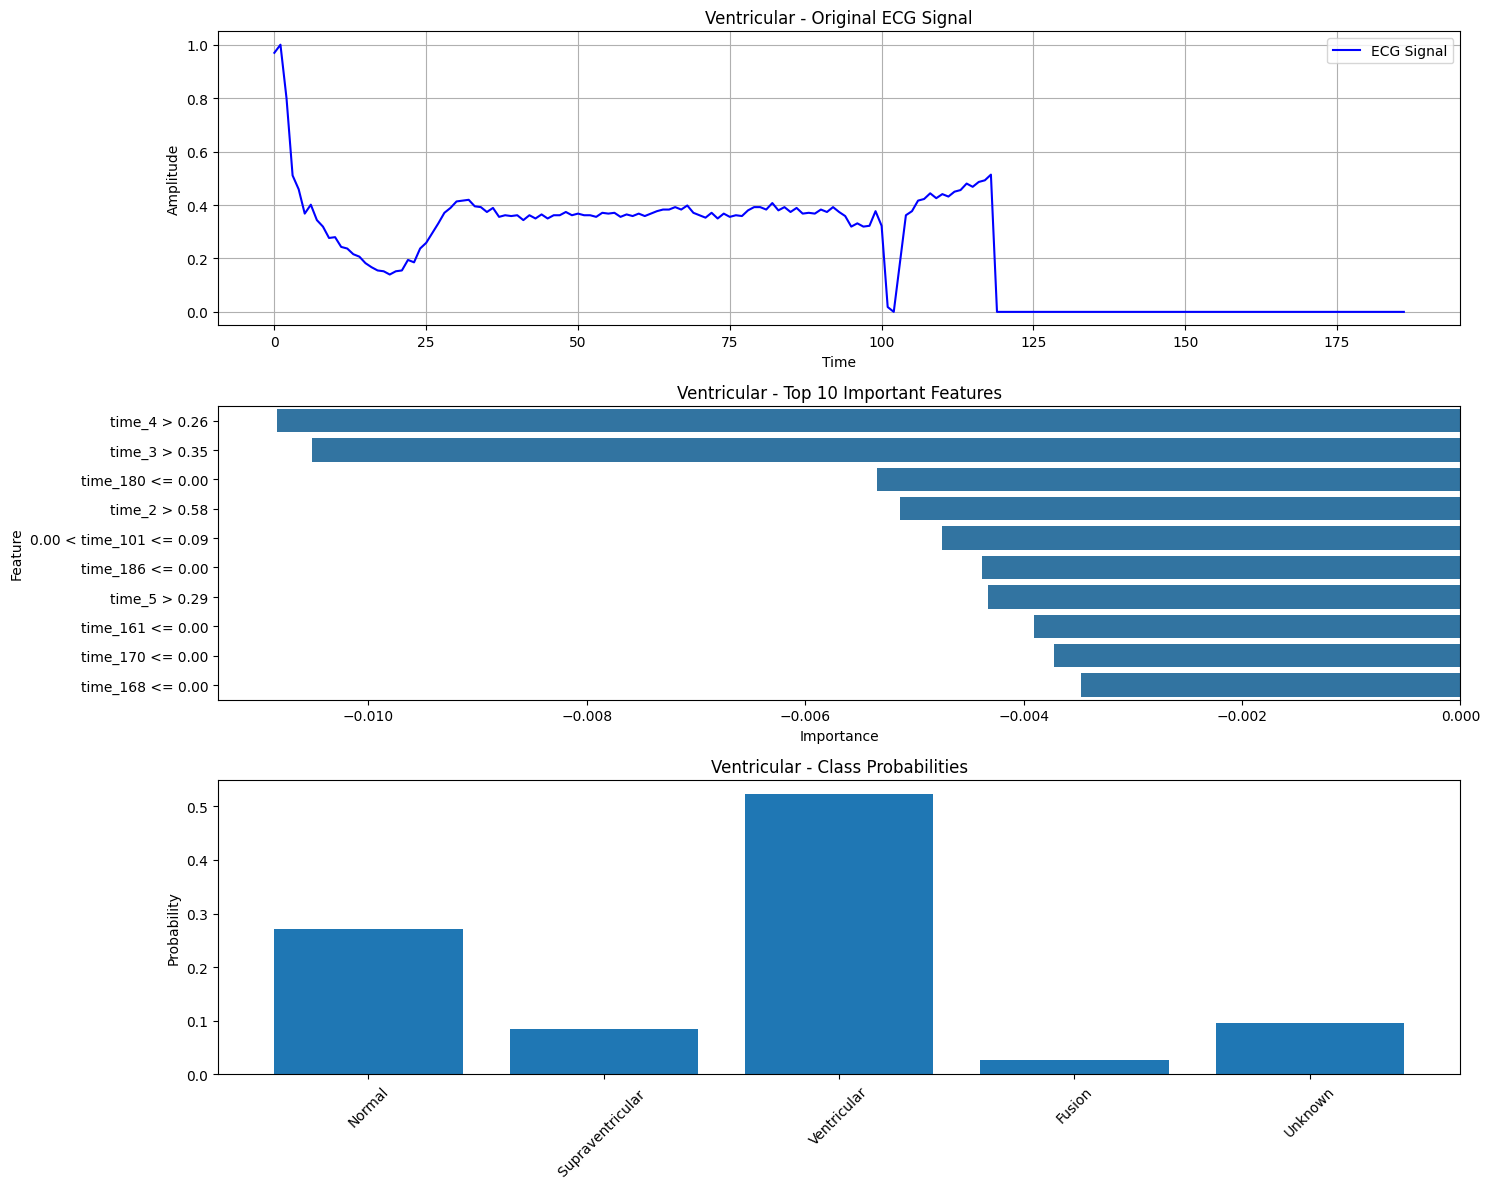




Class: Fusion (Sample Index: 20158)
--------------------------------------------------

Class Probabilities:
Normal: 0.0123
Supraventricular : 0.0111
Ventricular: 0.0082
Fusion: 0.9563
Unknown: 0.0121

Predicted Class: Fusion
Confidence: 0.9563


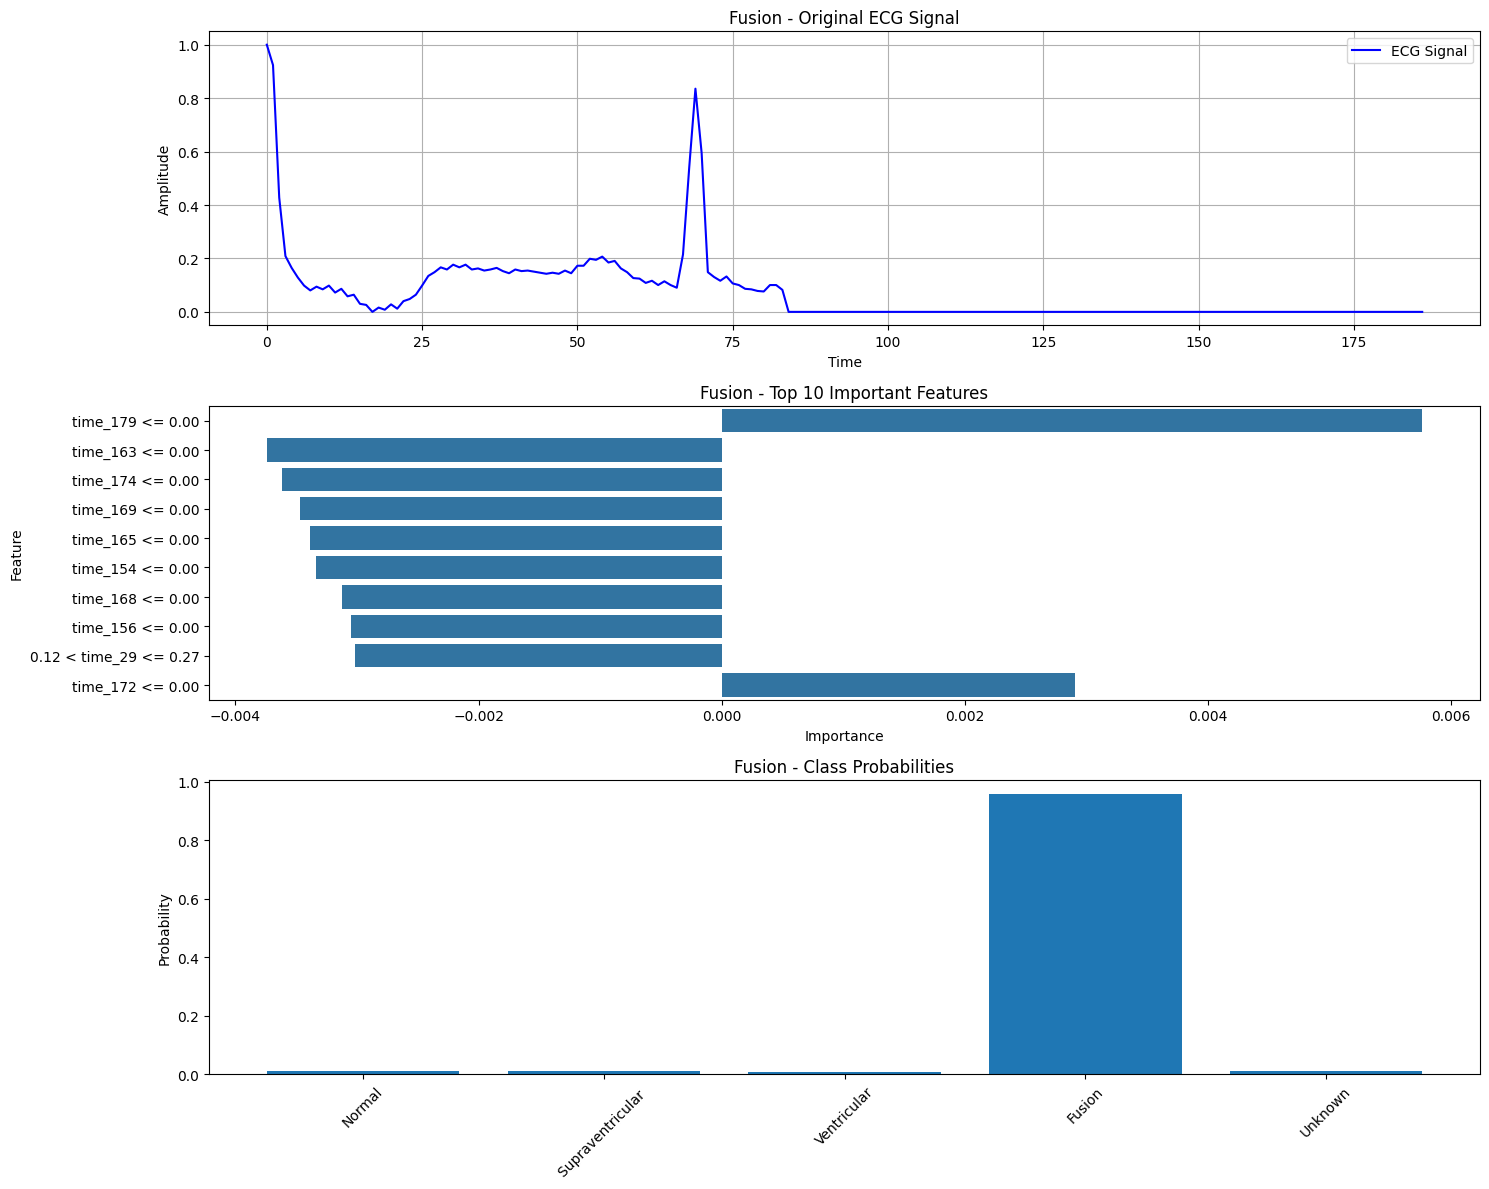




Class: Unknown (Sample Index: 21701)
--------------------------------------------------

Class Probabilities:
Normal: 0.0070
Supraventricular : 0.0111
Ventricular: 0.0078
Fusion: 0.0072
Unknown: 0.9669

Predicted Class: Unknown
Confidence: 0.9669


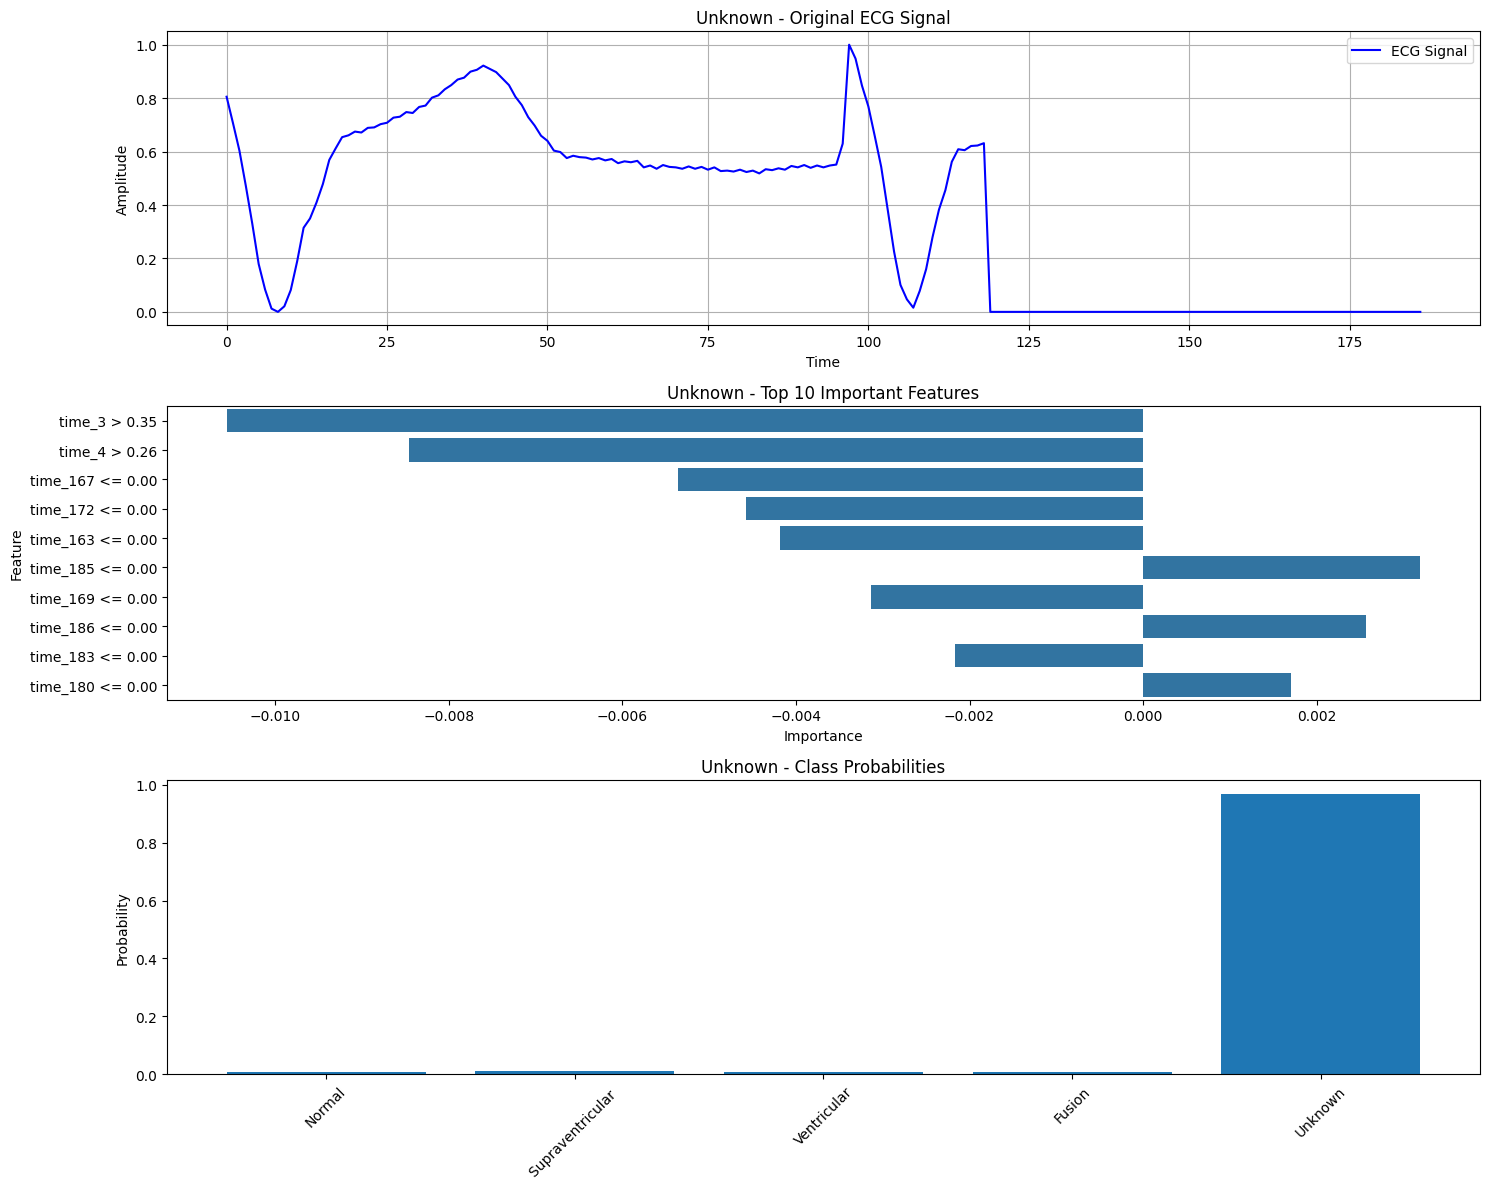

In [12]:
run_class_analysis(gru_model, X_test, y_test, 187)